In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
# Get the device
if (torch.cuda.is_available()):
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")


"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

# Data Processing

In [26]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./argo2/"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

# # intialize a dataset
city = 'austin' 
split = 'train'

def normalize(trajectories):
    minxy = np.min(trajectories, axis=-1)
    maxxy = np.max(trajectories, axis=-1)
    scale = np.max(maxxy - minxy) / 2.0
    return (trajectories / scale), scale

def unnormalize(trajectories, scale):
    return trajectories * scale


def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    
    outputs = None
    
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[:int(n * 0.8)]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[:int(n * 0.8)]
        
    elif split == 'val':
        f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[int(n * 0.8):]
        
        f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[int(n * 0.8):]
    
    else:
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        
#         tensor = torch.Tensor(self.feature[item])
#         tensorlabel = torch.Tensor(self.label[item])
#         return tensor.to(device), tensorlabel.to(device)

        data = np.concatenate((self.inputs[idx], self.outputs[idx]))
            
        if self.transform:
            data = self.transform(data)

        return torch.Tensor(data).to(device)
    
# every path has length 110, with the 110nd character as target value
# set range step higher if overfit     
# if dataArr is with velocity, remove for y labels
def create_set(dataArr, normalization=False):
    normArr = dataArr
    scale = 0
    set_x = []
    set_y = []
    if(normalization):
        normArr, scale = normalize(dataArr)
    for path in normArr:
            set_x.append(path[:109])
            set_y.append(path[109])
    return set_x, set_y, scale

class mydataset(Dataset):
    def __init__(self, x, y):
        
        self.feature = x
        self.label = y
        
    def __getitem__(self, item):
        
        tensor = torch.Tensor(self.feature[item])
        tensorlabel = torch.Tensor(self.label[item])
        return tensor.to(device), tensorlabel.to(device)
    
    def __len__(self):
        return len(self.feature)
    
# input: n*110*2 paths
# output: n*110*4 paths with dim2 = [x,y,Vx,Vy], where Vx, Vy are velocity with length/.1s as unit
def addVelocity(dataArr):
    dataWV = []
    for path in np.array(dataArr):
        pathWV = []
        pathWV.append(np.concatenate((path[0], [0,0])))
        for coord in range(1, len(path)):
            vel = path[coord] - path[coord-1]
            coordWV = np.concatenate((path[coord], vel))
            pathWV.append(coordWV)
        dataWV.append(pathWV)
    return np.array(dataWV)

def calcVelocity(dataArr):
    dataWV = []
    for path in np.array(dataArr):
        pathWV = []
        pathWV.append(path[1] - path[0])
        for coord in range(1, len(path)):
            vel = path[coord] - path[coord-1]
            pathWV.append(vel)
        dataWV.append(pathWV)
    return np.array(dataWV)

# shifts every path to be starting from 0,0
# returns shifted data Array, each array's shifted value
def toOrigin (dataArr):
    dataO = []
    shiftArr = []
    for path in np.array(dataArr):
        pathO = []
        shifter = path[0]
        shiftArr.append(shifter)
        for coord in range(len(path)):
            shifted = path[coord] - shifter
            pathO.append(shifted)
        dataO.append(pathO)
    return dataO, shiftArr

# tempNorm, tempScale = normalize(all_in_1)
# tempunNorm = unnormalize(tempNorm, tempScale)
# print ("tempNorm", tempNorm)
# print ("unNorm", tempunNorm)
# print ("original", np.array(all_in_1))


    

# training_set_x, training_set_y, scale = create_set(all_in_1_WV)
# train_dataset = mydataset(training_set_x, training_set_y)

# velArr = np.array(calcVelocity(all_in_1))
# all_in_1_O, shiftVel = toOrigin(all_in_1)
# # define training set with velocity + shifted to origin
# all_in_1_WV = addVelocity(all_in_1_O)
# training_set_x, training_set_y, scale = create_set(all_in_1_WV, normalization=False)
# train_dataset = mydataset(training_set_x, training_set_y)



In [4]:
# print(np.array(training_set_y).shape)
# print(training_set_x[0])

In [5]:

# get train data
inputs, outputs = get_city_trajectories(city=city, split=split, normalized=False)
all_in_1 = []
for i in range(len(inputs)):
    togetherData = np.concatenate((inputs[i], outputs[i]))
    all_in_1.append(togetherData)


# Get Validation Data
inputs, outputs = get_city_trajectories(city=city, split='val', normalized=False)
val_in_1 = []
for i in range(len(inputs)):
    togetherData = np.concatenate((inputs[i], outputs[i]))
    val_in_1.append(togetherData)
    
# random subsampling from val_set to make faster validation
numValPath = 300
val_index = np.random.choice(len(val_in_1), numValPath, replace=False)
val_in_1_500 = np.array(val_in_1)[val_index]


In [6]:
import matplotlib.pyplot as plt
import math

# takes in a path and return x,y lists
def parsePath(path):
    tempX = []
    tempY = []
    for elem in path:
        tempX.append(elem[0])
        tempY.append(elem[1])
    return tempX, tempY

def showPath(x,y):
    plt.scatter(x[0:50],y[0:50], c='b')
    plt.scatter(x[50:],y[50:], c='r')

# gets the angle to rotate to pointing (1,1) in radians
# the path needs to be shifted to (0,0) in the beginning
# path should only have (x,y), i.e. without velocity
def getAngle(path):
#     shifted path starts at (0,0), so path[1] is its initial facing direction
    direction = path[1]
#     target direction
    targetVec = np.array([1,1])
    x1 = path[1][0]
    x2 = 1
    y1 = path[1][1]
    y2 = 1
        #     magnitude of direction vector for angle calculation, sqrt(2) is targetVec's magnitude
    dot = x1*x2 + y1*y2      # dot product
    det = x1*y2 - y1*x2      # determinant
    angle = math.atan2(det, dot)  # atan2(y, x) or atan2(sin, cos)
    return angle
    
    
#   rotate the x,y with angle (as vector)
# returns rotated x,y
def rotatePoint(x, y, rad):
    xR = x*math.cos(rad) - y*math.sin(rad)
    yR = y*math.cos(rad) + x*math.sin(rad)
    return xR, yR

# rotate the paths in the data to initialize to the same direction
# takes in the data and logArr for converting result back (logArr should contain the shift value)
# returns rotated datapath, new logarr with angles corresponding to each path to rotate back (construct original long/lat)
def rotateData(data, logArr):
#     logArr should have same lenth with data, since each path is shifted to (0,0)
    newLogArr = []
    dataR = []
    for i,path in enumerate(data):
        pathR = []
        ang = getAngle(path)
        newLogArr.append(np.concatenate((logArr[i], [ang])))
#         for each point, rotate them to math the orientation(except (0,0))
        pathR.append(path[0])
        for j in range(1, len(path)):
            xp = path[j][0]
            yp = path[j][1]
#             get rotated point
            xR, yR = rotatePoint(xp, yp, ang)
            pathR.append([xR,yR])
        dataR.append(pathR)
    return dataR, newLogArr

# shift & rotate data, takes in a raw data array (arbitrary length of paths, but each path has (x,y) points)
# returns processed data (without velocity added, but shifted to origin & rotated)
def shiftAndRotate(data):
#     shift data, get shifted array & shifted values for converting back
    data_O, shiftLog = toOrigin(data)
#     get rotated data & logs for converting back
    data_RO, logArr = rotateData(data_O, shiftLog)
    return np.array(data_RO), logArr

# takes in raw dataset and prep(shift to origin -> unify starting direction -> add velocity -> return proessedDataSet, convBackArr)
# the normalized = false since we already shifted data to origin.
def prepDataSet(data, normalized=False):
    # shift & rotate data
    processedData, convBackArr = shiftAndRotate(data)
    
    # now we have shifted & rotated data, then add velocity
#     Testing without velocity: TODO: If bad, put it back!!!==========================================
    data_WV = addVelocity(processedData)
    set_x, set_y, scale = create_set(data_WV, normalization=normalized)
    
    processedDataSet = mydataset(set_x, set_y)
    return processedDataSet, convBackArr

In [7]:
# trying normalization
train_set, trainConvBack = prepDataSet(all_in_1, normalized=True)
val_set, valConvBack = prepDataSet(val_in_1_500, normalized=True )

Data Processing Done (shift to origin -> unify starting direction -> add velocity -> return proessedDataSet, convBackArr)

# DataLoader

In [8]:
batch_sz = 64  # batch size 
train_loader = DataLoader(train_set,batch_size=batch_sz, shuffle = True)
val_loader = DataLoader(val_set, batch_size=batch_sz, shuffle = True)

# LSTM Model Implementation

In [9]:
from torch import nn, optim

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        #Hidden dimensions
        self.hidden_dim = hidden_dim
        
        #Number of hidden layers
        self.layer_dim = layer_dim
        
        #imput dim
        self.input_dim = input_dim
        
        
        #Building your LSTM
        #batch_first=True causes input/output tensors to be of shape
        #(batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        
        #Readout layer
        self.fc = nn.Linear (hidden_dim, output_dim)
        
        
    def forward(self, x):
        #Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        
        #Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        
        
        #Output channel
        output, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        hn = hn.view(-1,self.hidden_dim)
        out = self.fc(hn)
        
        return out

# Hyper Parameters

In [63]:
# define hyper parameters
learning_rate = 0.0005
epochs = 5
input_dim = 4
hidden_dim = 250
layer_count = 1
output_dim = 4

lstm = LSTMModel(input_dim, hidden_dim, layer_count, output_dim).to(device)
print(device, "\n", lstm)

# loss = nn.CrossEntropyLoss()
loss = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# visualize the inner data shape
for name, param in lstm.named_parameters():
    if param.requires_grad:
        print (name, param.data.shape)

cuda:0 
 LSTMModel(
  (lstm): LSTM(4, 250, batch_first=True)
  (fc): Linear(in_features=250, out_features=4, bias=True)
)
lstm.weight_ih_l0 torch.Size([1000, 4])
lstm.weight_hh_l0 torch.Size([1000, 250])
lstm.bias_ih_l0 torch.Size([1000])
lstm.bias_hh_l0 torch.Size([1000])
fc.weight torch.Size([4, 250])
fc.bias torch.Size([4])


# Training Function

In [64]:
import time
import matplotlib.pyplot as plt
lossArr = []
# tranining function
def train(dataloader, model, patience=3):
#     enable gradients
    model.train()
    print("Begin time: ", time.ctime())
    last_loss = 0
    patience= patience
    for epoch in range(epochs):
        totalLoss = 0
        for batch , (x,y) in enumerate(dataloader):
            optimizer.zero_grad()
            pred = model(x)
            trainLoss = loss(pred, y)
            totalLoss += trainLoss.item()
            trainLoss.backward()
            optimizer.step()
        lossArr.append(totalLoss)
        print("Time: ", time.ctime() , "epoch: ", epoch, "loss: ", totalLoss)
        
        #        early stopping
#         TODO: change this into validation set! make a smaller validation set
        if (last_loss < totalLoss and last_loss != 0):
            print("EarlyStopping remain patience: ", patience)
            if (patience <= 0):
                print ("Early Stopped")
                return
            patience -= 1
        last_loss = totalLoss

# Training The Model

In [65]:
train(train_loader, lstm)

Begin time:  Fri May 27 16:01:07 2022
Time:  Fri May 27 16:01:15 2022 epoch:  0 loss:  2.989056077578425
Time:  Fri May 27 16:01:22 2022 epoch:  1 loss:  0.014785228636810643
Time:  Fri May 27 16:01:30 2022 epoch:  2 loss:  0.004415797346382533
Time:  Fri May 27 16:01:37 2022 epoch:  3 loss:  0.0045043672415658875
EarlyStopping remain patience:  3
Time:  Fri May 27 16:01:45 2022 epoch:  4 loss:  0.0028085872736482997


In [55]:
# save the trained model
# torch.save(lstm.state_dict(), "trained_lstm" + "_lr%s_epoch%d_hd%d_%s" % (str(learning_rate), epochs, hidden_dim, city))
# numpy.save("./lossArr/" + "trained_lstm" + "_lr%s_epoch%d_hd%d_%s" % (str(learning_rate), epochs, hidden_dim, city), lossArr)
# load the trained model
# lstm.load_state_dict(torch.load("trained_lstm_lr0.001_epoch20_hd100_austin"))


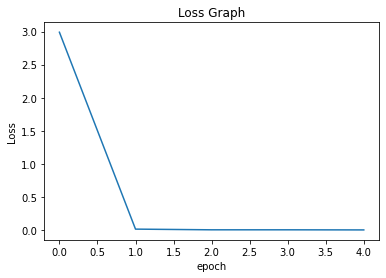

In [66]:
plt.plot(lossArr)
plt.title('Loss Graph')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()

# Testing

In [57]:
def predict(seed, model):
    model.eval()
    res = model(seed.to(device))
    res = res.cpu().detach().numpy()
    return res

def test(dataloader, model):
    model.eval()
    size = len(dataloader.dataset)
    testLoss, correct = 0,0
    with torch.no_grad():
        for batch, (x,y) in enumerate(dataloader):
            pred = model(x)
            testLoss += loss(pred, y).item()
    testLoss /= size
    print(f"Test Error: \n Avg loss: {testLoss:>8f} \n")

In [58]:
test(val_loader, lstm)

Test Error: 
 Avg loss: 0.000000 



In [59]:
# predict an entire path
def genPath(seed, model):
    path_w_seed = seed
#     for i in range(target_length - len(seed)):
    for i in range(60):
#         print (len(torch.Tensor(path_w_seed[i:i + 50])))
        path_w_seed = np.concatenate((path_w_seed, predict(torch.Tensor(path_w_seed).unsqueeze(0), model)))
#         print(len(path_w_seed))
    return path_w_seed


def processDataSet(data, normalized=False):
    scale = 0
    if (normalized):
        processedData, convBackArr = shiftAndRotate(data)
        normalization, scale = normalize(processedData)
        data_WV = addVelocity(normalization)
        return data_WV, convBackArr, scale
    
    
    processedData, convBackArr = shiftAndRotate(data)
    # now we have shifted & rotated data, then add velocity
    data_WV = addVelocity(processedData)
    
    return data_WV, convBackArr, scale



In [33]:
testDataSet, testBackArr, testScale = processDataSet(all_in_1, normalized = True)
valDataSet, valBackArr, valScale = processDataSet(val_in_1, normalized = True)

In [67]:
res = predict(torch.Tensor(valDataSet[300][0:80]).unsqueeze(0), lstm)
print(res)
print(valDataSet[300][80])
print(testScale)

[[0.67081285 0.6510246  0.00418696 0.00429   ]]
[0.67976025 0.66140579 0.00946403 0.00954118]
90.29789886317052


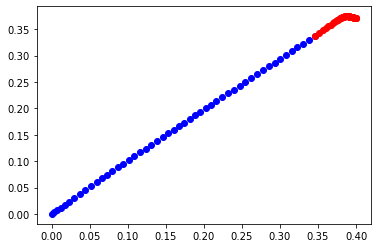

In [70]:
pathTest = genPath(testDataSet[531][0:50], lstm)
xPath, yPath = parsePath(pathTest)
showPath(xPath, yPath)

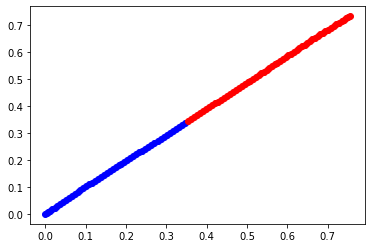

In [71]:
xPathT, yPathT = parsePath(testDataSet[531])
showPath(xPathT, yPathT)

# test rotation
for path in processedData[6:7]:
    velX , velY = parsePath(path)
    showPath(velX, velY)


def rotateBack(path, ang):
    pathR = []
    ang = ang*(-1)
#         for each point, rotate them to math the orientation(except (0,0))
    pathR.append(path[0])
    for j in range(1, len(path)):
        xp = path[j][0]
        yp = path[j][1]
#             get rotated point
        xR, yR = rotatePoint(xp, yp, ang)
        pathR.append([xR,yR])
    return pathR

pathBack = rotateBack(processedData[6], convBackArr[6][2])

def rotateTest(path):
    pathR = []
    ang = getAngle(path)
#         for each point, rotate them to math the orientation(except (0,0))
    pathR.append(path[0])
    for j in range(1, len(path)):
        xp = path[j][0]
        yp = path[j][1]
#             get rotated point
        xR, yR = rotatePoint(xp, yp, ang)
        pathR.append([xR,yR])
    return pathR

tempPath = [[0,0],[-1,-2],[-2,-3],[-3,-3]]
ang = getAngle(tempPath)
print(ang)
rotatedP = rotateTest(tempPath)
orgX, orgY = parsePath(tempPath)
velX , velY = parsePath(rotatedP)
plt.plot(orgX,orgY,linestyle='solid',color='blue')
plt.plot(velX,velY,linestyle='solid',color='red')
plt.scatter(1,1,color='green')